## Soma model extracted from L5

#### (new SomaOnly child class of the Cell class) 

In [1]:
import os
os.chdir('../../')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from neuron import h
from neurostim.cell import Cell
from neurostim.simulation import SimControl
from neurostim.stimulator import Stimulator
from neurostim.utils import convert_polar_to_cartesian_xz
from neurostim.analysis import get_AP_times
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [3]:
class SomaOnly(Cell):
    name = 'SomaOnlyModel'

    def __init__(
        self,
        gid=0,
        hoc_file="simneurostim/model/hoc/L5.hoc",
        cortical_depth={'L23': 400, 'L5': 1170},
        ChR_soma_density=13e9,
        ChR_distribution="uniform",
        rm_mech_from_secs=None,
    ):
        super().__init__(hoc_file, cortical_depth, ChR_soma_density, ChR_distribution, rm_mech_from_secs)

        self._gid = gid
        self._strip_redundant_morphology()
        self._strip_child_relations()
        self._strip_redundant_coords()

    
    def _strip_redundant_morphology(self):
        assert (h.soma in h.allsec()), "Soma not found."
        
        for sec in h.allsec():
            if sec.name() != "soma":
                h.delete_section(sec=sec)
            else:
                self.soma = sec

    def _strip_child_relations(self):
        self.soma_child_relations = None

    def _strip_redundant_coords(self):
        self.segs_coord = self.segs_coord["soma"]
    
    def _setup_morphology(self): # unused
        h.finitialize()
        pass

    def _setup_biophysics(self): # unused 
        h.finitialize()
        pass

    def change_biophysics(self, changes): # {'g_pas': 0.000033, 'gbar_na': 0.12, ..}
        for property_name, value in changes.items():
            for seg in self.soma:
                try:
                    setattr(seg, property_name, value)
                except AttributeError:
                    print(f"Property {property_name} not found in segment in the soma section.")
        
        h.finitialize()

    def _find_section_by_name(self, sec_name): # unused
        for sec in h.allsec():
            if sec.name() == sec_name:
                return sec
        return None

    def _scale_size_L(self, scale, verbose=0):
        
        if verbose:
            for seg in self.soma:
                print(f"BEFORE: cm:{seg.cm}, area:{seg.area()}, volume:{seg.volume()}, sizeof:{seg.__sizeof__()}, diam:{seg.diam}")
            print()
        
        self.soma.L *= scale

        if verbose:
            for seg in self.soma:
                print(f"AFTER: cm:{seg.cm}, area:{seg.area()}, volume:{seg.volume()}, sizeof:{seg.__sizeof__()}, diam:{seg.diam}")
        
        #h.finitialize() does not let me
    
    def plot_soma(self):
        fig, ax = plt.subplots()
        collection = self.plot_foutz2012(
             func=lambda x:1, axes='xz',scaling = 1, segfunc=False, clim=None,cmap=None,color='black', shift_x=0)
        ax.add_collection(collection)
        ax.axis('equal')

In [4]:
h.load_file("stdrun.hoc")
h.cvode_active(1)

1.0

In [5]:
L5soma = SomaOnly(0) # cant create more instances because in cell.py 'h.' is used instead of object's parameters
# L5somaChanged = SomaOnly(1)

	1 
	1 
	1 
	1 


In [6]:
# L5soma.change_biophysics({'gbar_na': na, 'gbar_kv': k})

In [7]:
default_na = L5soma.soma(0.5).gbar_na
default_k = L5soma.soma(0.5).gbar_kv

print(f"Default gbar_na = {default_na}")
print(f"Default gbar_kv = {default_k}")

stimulator = Stimulator(
    diameter_um=200, 
    NA=0.22
)

base_rec_vars = (
    ['time [ms]', 'V_soma(0.5)'],
    ['h._ref_t', 'h.soma(0.5)._ref_v'],
)

expanded_rec_vars = (
    ['time [ms]', 'V_soma(0.5)', 'g_Na', 'g_K',
     'm', 'n', 'h'],
    ['h._ref_t', 'h.soma(0.5)._ref_v', 'h.soma(0.5).na._ref_gna', 'h.soma(0.5).kv._ref_gk',
     'h.soma(0.5).na._ref_m', 'h.soma(0.5).kv._ref_n', 'h.soma(0.5).na._ref_h']
)

Default gbar_na = 256.752
Default gbar_kv = 64.188


### Parameter search

- df (na, k densities)
- ramp intensity
- bisection (bin search pro intensity)
- function that tries to say if 1 or 0 (DB)
- and store the voltage timestamp (where the DB first occured)
- match data of the article
- RGC

In [8]:
def depolarization_block(sim_data, intensity, min_elev_depolarization=-40, last=0.25, restrict_var=1, t_on=10, t_off=210) -> bool:
    """ restrict was 15
    Returns True if the cell undergoes depolarization block, False otherwise.
    -----
    sim_data: DataFrame
        data from sim_control.run()
    min_elev_depolarization: float
        the minimal value that the voltage can have
        in the blocking interval to be classified as DB
    last: float [0, 0.5]
        the last fraction of the stimulation period that
        will be classified as the blocking interval
    t_on: int [ms]
        time of stimulation onset (delay included)
    t_off: int [ms]
        time of the end of the stimulation (delay included)
    """
    AP_times_df = get_AP_times(sim_data, interpol_dt=0.1, t_on=t_on, AP_threshold=0, apply_to="V_soma(0.5)")
    
    # check if there are any spikes, if none, return False
    if len(AP_times_df) == 0:
        return False
    
    # check if the last proper spike occured within the first half of the stimulation and
    # if the cell stays reasonably depolarized until the end of the stimulation
    # and if the variance gets progressively lower
    first_spike_t, last_spike_t = AP_times_df.iloc[0], AP_times_df.iloc[-1]
    blocked_interval = sim_data[(sim_data['time [ms]']-t_on >= (1-last)*(t_off-t_on)) & (sim_data['time [ms]'] < t_off)]

    if first_spike_t-t_on < (t_off-t_on)/2 and last_spike_t-t_on < (1-last)*(t_off-t_on):
        if blocked_interval['V_soma(0.5)'].mean() >= min_elev_depolarization:
            if blocked_interval['V_soma(0.5)'].var() < restrict_var:
                return True

        # further restrictions if needed
        #and blocked_interval[blocked_interval['time [ms]']-t_on < (t_off-t_on) - (((t_off-t_on)-(1-last)*(t_off-t_on)) / 2)]['V_soma(0.5)'].var() >\
        #blocked_interval[blocked_interval['time [ms]']-t_on >= (t_off-t_on) - (((t_off-t_on)-(1-last)*(t_off-t_on)) / 2)]['V_soma(0.5)'].var():
    
    return False


def simulate(cell, intensity, rec_vars=base_rec_vars) -> list:
    """
    Simulates the cell and returns the simulation data for a given intensity.
    -----
    cell: neurostim.cell's Cell instance
        Cell class' or its child class' instance
    intensity: float
        light stimulation intensity
    """
    simcontrol = SimControl(
        cell=cell,
        stimulator=stimulator
    )

    sim_data = simcontrol.run(
        temp_protocol=dict(
            duration_ms=200,
            delay_ms=10,
            total_rec_time_ms=230,
        ),
        stim_location=(0, 0, 0),
        stim_intensity_mWPERmm2=intensity,
        rec_vars=rec_vars,
        interpol_dt_ms=0.1,
    )

    return sim_data


def find_intensity_threshold(cell, precision) -> float:
    """
    Perform a bisect search to find the intensity threshold with a given precision.
    When the DB does not occur at all, then the max value of the search range is returned.
    -----
    precision: float
        the interval when the bisect search stops searching
        (is satisfied with the fact that the result is in
        the interval of length 'precision')
    """
    l, r = 0.0, 25_000 # was 2_500
    db_intensity = r
    
    while r - l > precision:
        intensity = (l + r) / 2

        sim_data = simulate(cell, intensity)
        
        if depolarization_block(sim_data, intensity):
            db_intensity = intensity
            r = intensity
        else:
            l = intensity
    
    return db_intensity


# create a domain of (D_na, D_k) values
# for each value in the domain, simulate the cell
# and find the lowest intensity that causes depolarization block
# for each value in the domain, save the lowest intensity in a dataframe
# plot the domain with the lowest intensity values

D_na = np.linspace(int(0.5 * default_na), int(2 * default_na), 10)
D_k = np.linspace(int(0.5 * default_k), int(2 * default_k), 10)

rows = []
for na in D_na:
    for k in D_k:
        L5soma.change_biophysics({'gbar_na': na, 'gbar_kv': k})
        rows.append({"na": na, "k": k, "intensity": find_intensity_threshold(L5soma, 1)})

results = pd.DataFrame(rows)

### Analysis

In [9]:
results.apply(lambda x: x.round(2))

,na,k,intensity
0,128.0,32.00,54.17
1,128.0,42.67,64.09
2,128.0,53.33,75.53
3,128.0,64.00,89.26
4,128.0,74.67,104.52
...,...,...,...
95,513.0,85.33,1963.81
96,513.0,96.00,2905.27
97,513.0,106.67,4833.98
98,513.0,117.33,8798.22


In [10]:
results.describe().apply(lambda x: x.round(2))

,na,k,intensity
count,100.00,100.00,100.00
mean,320.50,80.00,844.26
std,123.49,30.79,2068.19
min,128.00,32.00,48.07
25%,213.56,53.33,132.37
50%,320.50,80.00,216.29
75%,427.44,106.67,718.31
max,513.00,128.00,17564.39


In [90]:
print()
print("INTENSITY NEEDED TO INDUCE DPB IN REDUCED MODEL WITH DEFAULT CONDUCTANCE PARAMETERS")
print({"Default max g_NaV": default_na, "Default max g_Kv": default_k, "Intensity needed for DpB": find_intensity_threshold(L5soma, 1)})
print()


INTENSITY NEEDED TO INDUCE DPB IN REDUCED MODEL WITH DEFAULT CONDUCTANCE PARAMETERS
{'Default max g_NaV': 256.752, 'Default max g_Kv': 64.188, 'Intensity needed for DpB': 101.470947265625}



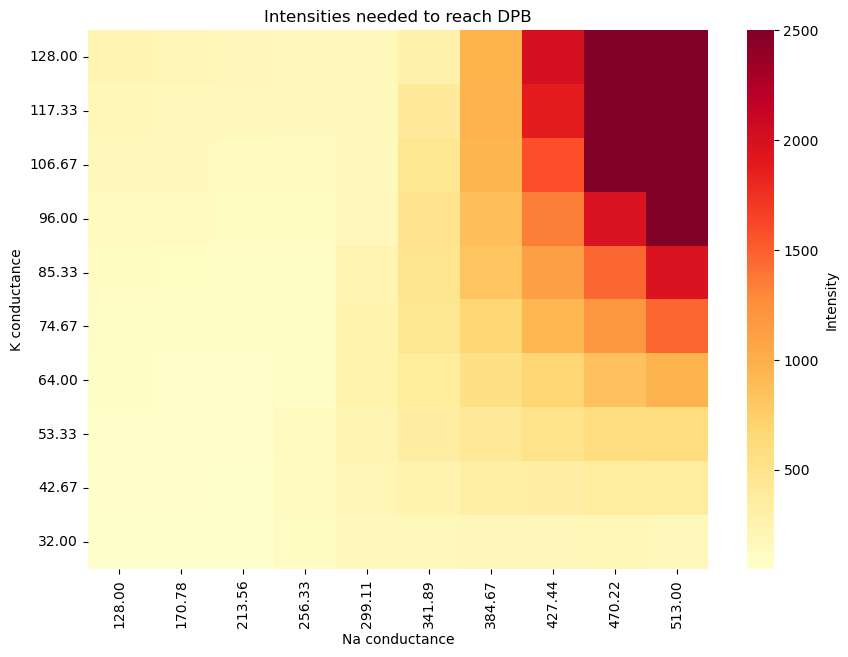

In [11]:
import seaborn as sns

pivoted_df = results.pivot(index="k", columns="na", values="intensity")
reversed_df = pivoted_df.iloc[::-1]  # This reverses the order of rows

plt.figure(figsize=(10, 7))
ax = sns.heatmap(reversed_df, cmap="YlOrRd", vmax=2500)

ax.set_xticklabels([f"{float(tick.get_text()):.2f}" for tick in ax.get_xticklabels()])
ax.set_yticklabels([f"{float(tick.get_text()):.2f}" for tick in ax.get_yticklabels()])

ax.set_title("Intensities needed to reach DPB") # min_elev = -40, last = 0.25, mean, first spike adjusted
ax.set_xlabel('Na conductance')
ax.set_ylabel('K conductance')
ax.collections[0].colorbar.set_label('Intensity')

# plt.savefig('heatmap_dpb_intensities.pdf', dpi=300)

## Simulation examples

I have installed ipywidgets and upgraded jupyterlab

At first i've tried to install it through pip but that was wrong. Conda install was the way.

Run this: '!conda install -c conda-forge ipywidgets --yes'

In [12]:
def show_sim_result(na, k, intensity):
    L5soma.change_biophysics({'gbar_na': na, 'gbar_kv': k})
    sim_data = simulate(L5soma, intensity)
    sim_data.plot("time [ms]", "V_soma(0.5)")
    plt.text(150, min(-15, max(sim_data["V_soma(0.5)"])), f"DB = {depolarization_block(sim_data, intensity)}", fontsize=12, color='black')
    plt.title(f"na={na}, k={k}, intensity={intensity}")

def show_extended_sim_results(na, k, intensity=-1):
    def arrange_axes(ax):
        ax.legend()
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    L5soma.change_biophysics({'gbar_na': na, 'gbar_kv': k})
    if intensity == -1:
        intensity = find_intensity_threshold(L5soma, 1)
    sim_data = simulate(L5soma, intensity, expanded_rec_vars)
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
    # plt.text(150, min(-15, max(sim_data["V_soma(0.5)"])), f"DB = {depolarization_block(sim_data)}", fontsize=12, color='black')
    # plt.suptitle(f"na={na}, k={k}, intensity={intensity}")
    
    # Plot Voltage Trace on ax0
    ax0.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], label='Membrane Potential')
    ax0.set_title('Membrane Potential Over Time')
    ax0.set_ylabel('Voltage (mV)')
    arrange_axes(ax0)

    # Plot m, n, h functions on ax1
    ax1.plot(sim_data['time [ms]'], sim_data['m'], label='m (Na activation)', color='black')
    ax1.plot(sim_data['time [ms]'], sim_data['h'], label='h (Na inactivation)', color='red')
    ax1.plot(sim_data['time [ms]'], sim_data['n'], label='n (K activation)', color='blue')
    ax1.set_title('Channel Gating Variables Over Time')
    ax1.set_ylabel('Gating Variable Value')
    arrange_axes(ax1)
    
    # Plot Conductances on ax2
    ax2.plot(sim_data['time [ms]'], sim_data['g_Na'], label='Na Conductance')
    ax2.plot(sim_data['time [ms]'], sim_data['g_K'], label='K Conductance')
    ax2.set_title('Conductances Over Time')
    ax2.set_ylabel('Conductance')
    ax2.set_xlabel('Time (ms)')
    ax2.legend()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

### DPB at default channel properties

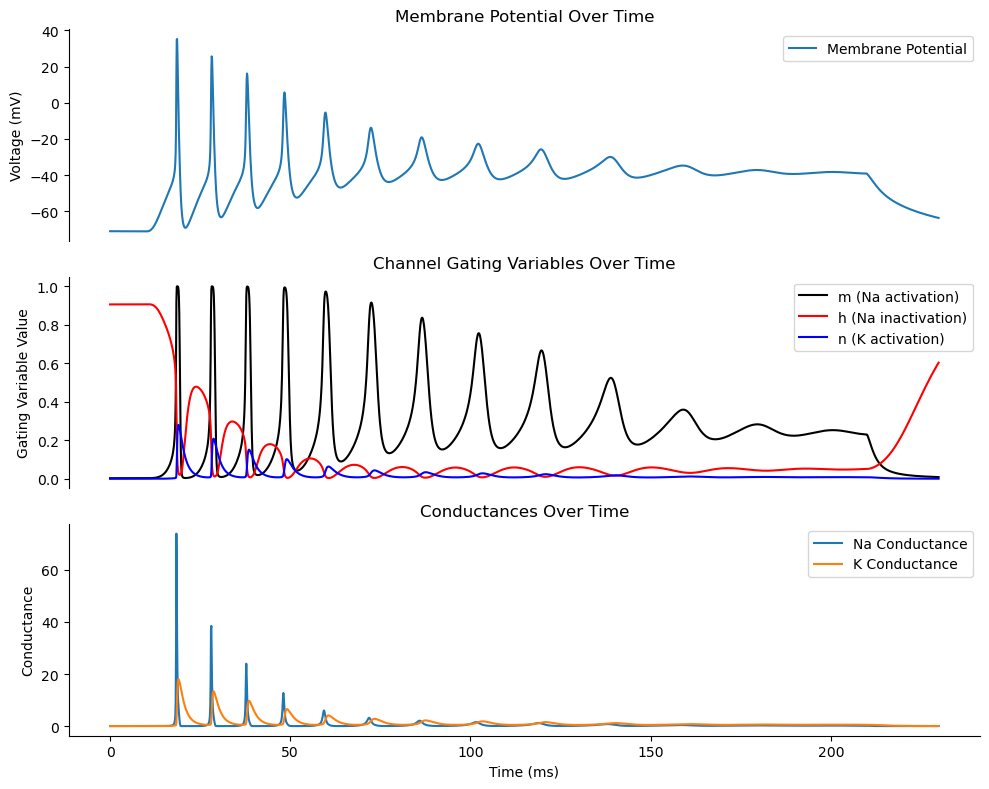

In [13]:
show_extended_sim_results(default_na, default_k)
# plt.savefig('dpb_extended_default.pdf', dpi=300) do show_extend.. function

### Shown with channel properties

In [15]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Output

output_widget = Output()
output_widget.layout.height = '800px'

def update_plot(na, k, intensity):
    with output_widget:
        output_widget.clear_output(wait=True)
        show_extended_sim_results(na, k, intensity)

def show_with_slider(na, k):
    L5soma.change_biophysics({'gbar_na': na, 'gbar_kv': k})
    thr_intensity = find_intensity_threshold(L5soma, 1)

    min_intensity = 0 # np.max([0, thr_intensity - 200])
    intensity_values = np.linspace(min_intensity, thr_intensity + 200, 10)
    
    intensity_slider = widgets.IntSlider(
        value=thr_intensity,
        min=min_intensity,
        max=np.max(intensity_values),
        step=(thr_intensity-min_intensity) / 20,
        description='Intensity'
    )

    display(intensity_slider)
    intensity_slider.observe(lambda change: update_plot(na, k, change['new']), names='value')
    display(output_widget)

In [16]:
show_with_slider(256.752, 64.188)

IntSlider(value=101, description='Intensity', max=301, step=5)

Output(layout=Layout(height='800px'))

### (Na, K) = (128, 32)
Let's see how our model looks at lowest values of our domain.

In [17]:
show_with_slider(128, 32)

IntSlider(value=54, description='Intensity', max=254, step=2)

Output(layout=Layout(height='800px'))

### (Na, K) = (513, 128)
Let's see how our model looks at the highest values of our domain.

In [18]:
show_with_slider(513, 128)

IntSlider(value=17564, description='Intensity', max=17764, step=878)

Output(layout=Layout(height='800px'))

We see that the block starts being visible when Na+ channels fail to inactivate completely (this is due to constant stimulation with higher intensity in the relative refractory period) -> leading to premature spike (which is lower than the spike before - due to inactivations still happening at the time of the spike itself). K+ channels' response to the lower spike is therefore lower as well.

This happens again and again until the Na+ channels are activated (open) enough to lead to a stable voltage (Na+ out K+ in).

In [19]:
def plot_all(na):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for index, row in results[results['na'] == na].iterrows():
        L5soma.change_biophysics({'gbar_na': na, 'gbar_kv': row['k']})
        sim_data = simulate(L5soma, row['intensity'])

        t_on, t_off, last = 10, 210, 0.25
        blocked_interval = sim_data[(sim_data['time [ms]']-t_on >= (1-last)*(t_off-t_on)) & (sim_data['time [ms]'] < t_off)]
        
        ax.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], alpha=0.5, color='black')

        ax.set_title(f"Traceplots for all Na={na}")

    ax.axhline(y=-25, color='grey', linestyle='--', linewidth=1, alpha=0.2)
    ax.axhline(y=-30, color='grey', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=-35, color='grey', linestyle='--', linewidth=1, alpha=0.2)
    ax.grid(True, which='both', axis='y', linestyle='--', color='grey', alpha=0.5, linewidth=1.5)
    
    ax.axvline(x=210, color='grey', linestyle='-', linewidth=1, alpha=0.5)
    ax.axvline(x=160, color='grey', linestyle='-', linewidth=1, alpha=0.5)

    plt.show()

In [20]:
widget = Output()
widget.layout.height = '500px'

def update_na_plot(na):
    with widget:
        widget.clear_output(wait=True)
        plot_all(na)

def show_all_traces_for_na():
    na_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(D_na)-1,
        step=1,
        description='D_na index'
    )

    display(na_slider)
    na_slider.observe(lambda change: update_na_plot(D_na[change['new']]), names='value')
    display(widget)

    update_na_plot(D_na[0])

In [21]:
show_all_traces_for_na()

IntSlider(value=0, description='D_na index', max=9)

Output(layout=Layout(height='500px'))

#### Mean values at the end of checked interval in relation to channel densities

In [22]:
def plot_against(against='na'):
    fig, ax = plt.subplots(figsize=(10, 5))

    domain = D_na if against == 'na' else D_k
    
    data_to_plot = []

    for val in domain:
        for index, row in results[results[against] == val].iterrows():
            if against == 'na':
                L5soma.change_biophysics({'gbar_na': val, 'gbar_kv': row['k']})
            else:
                L5soma.change_biophysics({'gbar_na': row['na'], 'gbar_kv': val})
            
            sim_data = simulate(L5soma, row['intensity'])
    
            t_on, t_off, last = 10, 210, 0.25
            blocked_interval = sim_data[(sim_data['time [ms]']-t_on >= (1-last)*(t_off-t_on)) & (sim_data['time [ms]'] < t_off)]

            data_to_plot.append({against: val, 'mean_voltage': blocked_interval['V_soma(0.5)'].mean()})

    new_df = pd.DataFrame(data_to_plot)

    sns.lineplot(data=new_df, x=against, y='mean_voltage', marker='X', linestyle='None', err_style='band', errorbar='sd', markerfacecolor='black',
                 err_kws={'alpha': 0.1}, ax=ax) 
    sns.scatterplot(data=new_df, x=against, y='mean_voltage', alpha=0.5, ax=ax)
    sns.lineplot(data=new_df, x=against, y='mean_voltage', marker='', linestyle='--', err_style=None, color='black', alpha=0.2, ax=ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Mean voltage of checked interval')
    ax.set_yticks(range(-50, -19, 5))
    ax.set_xticks(domain)
    ax.set_xticklabels([f'{i:.2f}' for i in domain])

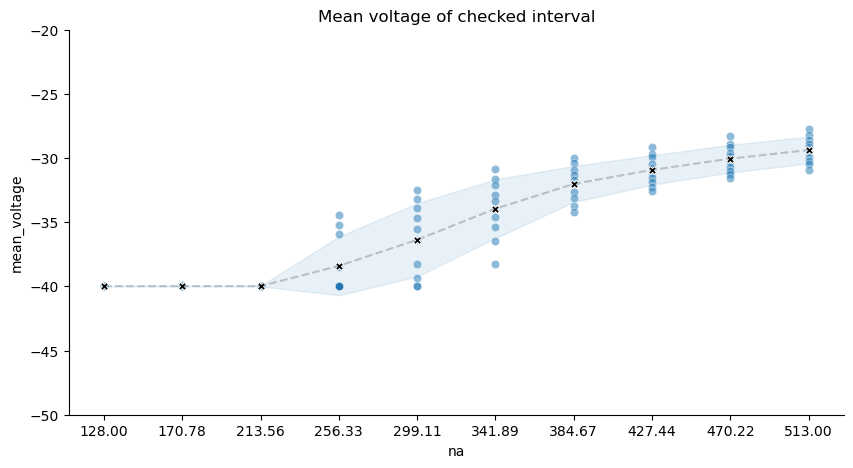

In [23]:
plot_against('na')
# plt.savefig('mean_voltage_na.pdf', dpi=300)

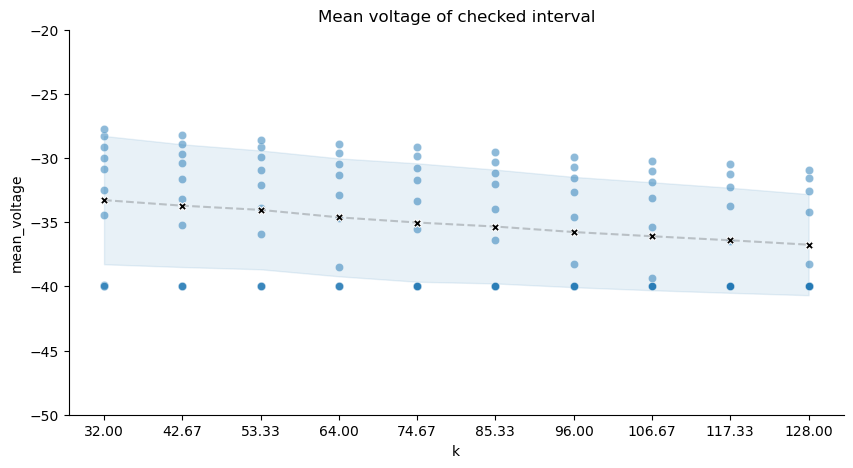

In [24]:
plot_against('k')
# plt.savefig('mean_voltage_k.pdf', dpi=300)

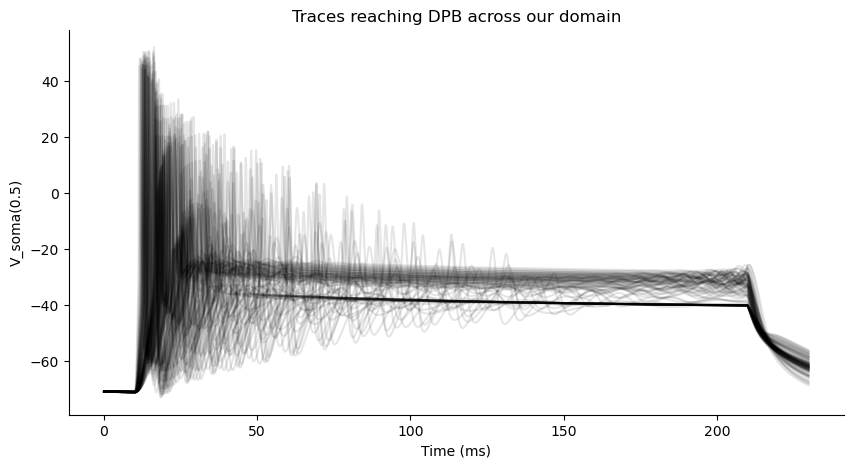

In [25]:
points = [(x, y) for x in D_na for y in D_k]

fig, ax = plt.subplots(figsize=(10, 5))

for point in points:
    row = results[(results['na'] == point[0]) & (results['k'] == point[1])]
    intensity = row['intensity'].iloc[0]

    L5soma.change_biophysics({'gbar_na': point[0], 'gbar_kv': point[1]})
    sim_data = simulate(L5soma, intensity)
    
    ax.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], alpha=0.1, color='black')#, linewidth=2 )#label=f'na={point[0]}, kv={point[1]}')


# Set labels and title
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V_soma(0.5)')
ax.set_title('Traces reaching DPB across our domain') # Simulation Results
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('dpb_traces.pdf', dpi=300)
plt.show()

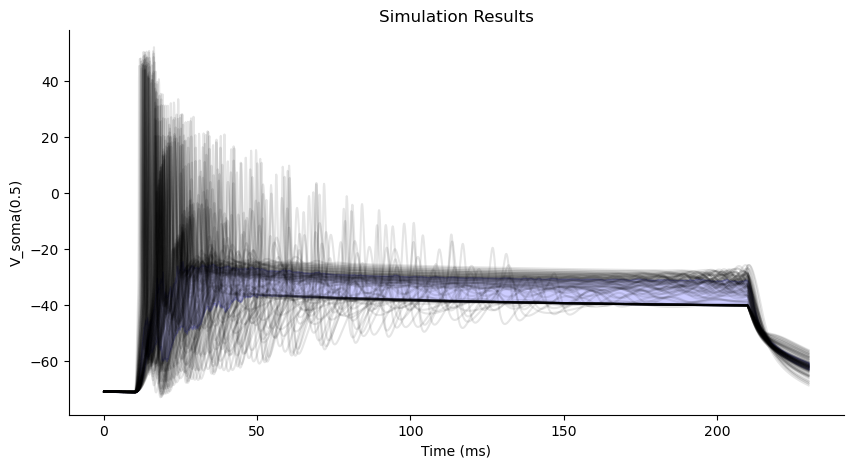

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))

# Store all y-values for each x-value to calculate quartiles later
y_values_per_time = {}

for point in points:
    row = results[(results['na'] == point[0]) & (results['k'] == point[1])]
    intensity = row['intensity'].iloc[0]

    L5soma.change_biophysics({'gbar_na': point[0], 'gbar_kv': point[1]})
    sim_data = simulate(L5soma, intensity)
    
    ax.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], alpha=0.1, color='black')

    # Aggregate y-values for quartile calculation
    for time, value in zip(sim_data['time [ms]'], sim_data['V_soma(0.5)']):
        if time not in y_values_per_time:
            y_values_per_time[time] = []
        y_values_per_time[time].append(value)

# Calculate and plot quartiles
times = sorted(y_values_per_time.keys())
lower_quartiles = [np.percentile(y_values_per_time[time], 25) for time in times]
upper_quartiles = [np.percentile(y_values_per_time[time], 75) for time in times]

ax.fill_between(times, lower_quartiles, upper_quartiles, color='blue', alpha=0.2)  # Fill between quartiles

# Set labels and title
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V_soma(0.5)')
ax.set_title('Simulation Results')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()


#### Correlation of conductance and intensity needed to induce DPB

In [27]:
import statsmodels.api as sm
import scipy.stats as stats

def get_linear_fit_results(x, y, robust=False):
    X = sm.add_constant(x)

    if not robust:
        model = sm.OLS(y, X).fit()
    else:
        model = sm.RLM(y, X).fit()
    
    coefs = model.params
    p_value = model.pvalues

    if not robust:
        r, _ = stats.pearsonr(x, y)
    else:
        r, _ = stats.spearmanr(x, y)
    
    return coefs, p_value, r

NON-ROBUST:                                                           ROBUST:
Coefficients: [-1528.5200350962957, 7.403373493072976]                Robust coefficients: [-505.36588491343946, 3.0883882843795756]
Correlation coefficient: 0.4420443901184685                           Robust corr: 0.8404873553297997


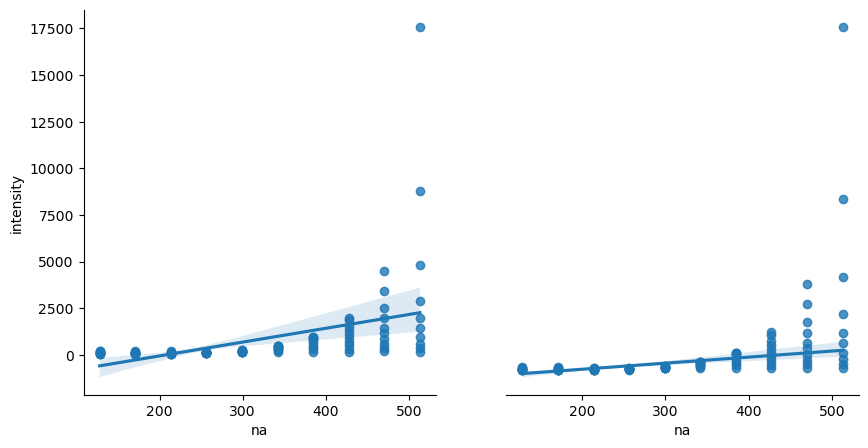

In [68]:
coefs, p_value, r = get_linear_fit_results(results['na'], results['intensity'], robust=False)
r_coefs, r_p_value, r_r = get_linear_fit_results(results['na'], results['intensity'], robust=True)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.regplot(x=results['na'], y=results['intensity'], robust=False, ax=ax0)
sns.regplot(x=results['na'], y=results['intensity'], robust=True, ax=ax1)

ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_ylabel('')
ax1.set_yticks([])

print("NON-ROBUST:" + (70 - 11)*" " + "ROBUST:")
print(f"Coefficients: {list(coefs)}" + (70 - 18 - np.sum([len(str(num)) for num in list(coefs)]))*" " + f"Robust coefficients: {list(r_coefs)}")
print(f"Correlation coefficient: {r}" + (70 - 25 - len(str(r)))*" " + f"Robust corr: {r_r}")

### DPB Zoomed In

#### For two values in the channel density domain

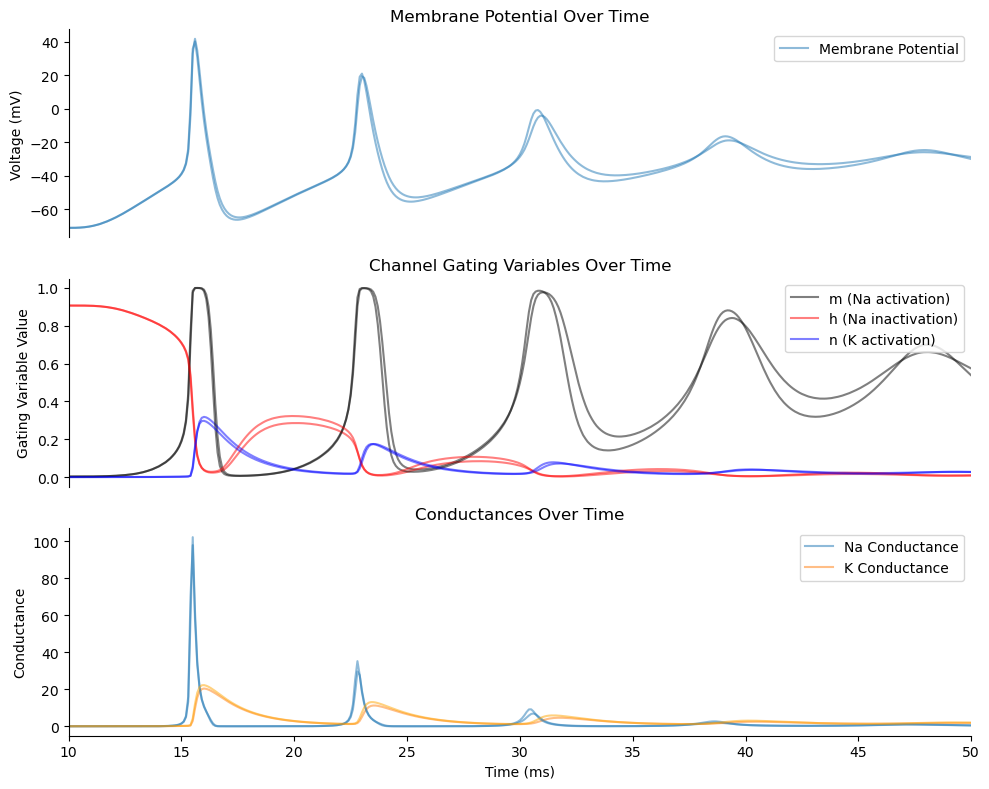

In [29]:
def arrange_axes(ax):
    ax.legend(loc='upper right')
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

first = True

for na in D_na[4:5]:
    for k in D_k[3:5]:
        L5soma.change_biophysics({'gbar_na': na, 'gbar_kv': k})
        sim_data = simulate(L5soma, float(results[(results['na'] == na) & (results['k'] == k)]['intensity'].iloc[0]), expanded_rec_vars)
        
        if first:
            # Plot Voltage Trace on ax0
            ax0.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], label='Membrane Potential', alpha=0.5)
            
            # Plot m, n, h functions on ax1
            ax1.plot(sim_data['time [ms]'], sim_data['m'], label='m (Na activation)', color='black', alpha=0.5)
            ax1.plot(sim_data['time [ms]'], sim_data['h'], label='h (Na inactivation)', color='red', alpha=0.5)
            ax1.plot(sim_data['time [ms]'], sim_data['n'], label='n (K activation)', color='blue', alpha=0.5)

            # Plot Conductances on ax2
            ax2.plot(sim_data['time [ms]'], sim_data['g_Na'], label='Na Conductance', alpha=0.5)
            ax2.plot(sim_data['time [ms]'], sim_data['g_K'], label='K Conductance', alpha=0.5)

            first = False
        else:
            ax0.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], color='#1f77b4', alpha=0.5)
            
            ax1.plot(sim_data['time [ms]'], sim_data['m'], color='black', alpha=0.5)
            ax1.plot(sim_data['time [ms]'], sim_data['h'], color='red', alpha=0.5)
            ax1.plot(sim_data['time [ms]'], sim_data['n'], color='blue', alpha=0.5)

            ax2.plot(sim_data['time [ms]'], sim_data['g_Na'], color='#1f77b4', alpha=0.5)
            ax2.plot(sim_data['time [ms]'], sim_data['g_K'], color='orange', alpha=0.5)

ax0.set_xlim(10, 50)
ax0.set_title('Membrane Potential Over Time')
ax0.set_ylabel('Voltage (mV)')
arrange_axes(ax0)

ax1.set_xlim(10, 50)
ax1.set_title('Channel Gating Variables Over Time')
ax1.set_ylabel('Gating Variable Value')
arrange_axes(ax1)                                   

ax2.set_xlim(10, 50)
ax2.set_title('Conductances Over Time')
ax2.set_ylabel('Conductance')
ax2.set_xlabel('Time (ms)')
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### For different intensities of default channel density

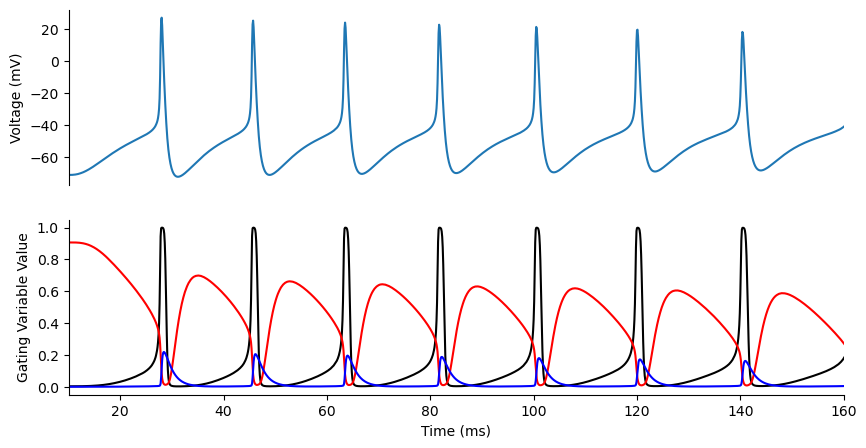

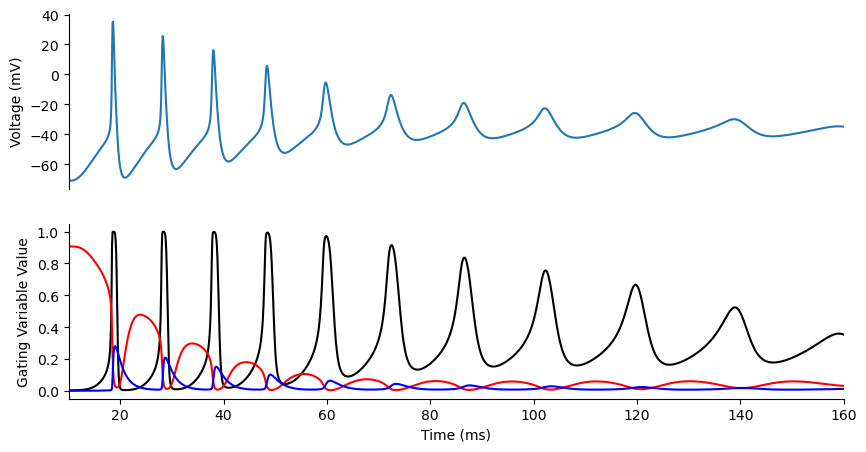

In [134]:
def set_borders_invisible(ax, let_bottom=False):
    ax.spines['top'].set_visible(False)
    if let_bottom == False:
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('Voltage (mV)')
        ax.spines['bottom'].set_visible(False)
    else:
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Gating Variable Value')
    ax.spines['right'].set_visible(False)
    ax.set_xlim(10, 160)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

L5soma.change_biophysics({'gbar_na': default_na, 'gbar_kv': default_k})
intensity = 30
sim_data = simulate(L5soma, intensity, expanded_rec_vars)

# Plot Voltage Trace on ax0
ax0.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], label='Membrane Potential')
set_borders_invisible(ax0)

# Plot m, n, h functions on ax1
ax1.plot(sim_data['time [ms]'], sim_data['m'], label='m (Na activation)', color='black')
ax1.plot(sim_data['time [ms]'], sim_data['h'], label='h (Na inactivation)', color='red')
ax1.plot(sim_data['time [ms]'], sim_data['n'], label='n (K activation)', color='blue')
set_borders_invisible(ax1, True)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

L5soma.change_biophysics({'gbar_na': default_na, 'gbar_kv': default_k})
intensity = find_intensity_threshold(L5soma, 1)
sim_data = simulate(L5soma, intensity, expanded_rec_vars)

# Plot Voltage Trace on ax0
ax0.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], label='Membrane Potential')
set_borders_invisible(ax0)

# Plot m, n, h functions on ax1
ax1.plot(sim_data['time [ms]'], sim_data['m'], label='m (Na activation)', color='black')
ax1.plot(sim_data['time [ms]'], sim_data['h'], label='h (Na inactivation)', color='red')
ax1.plot(sim_data['time [ms]'], sim_data['n'], label='n (K activation)', color='blue')
set_borders_invisible(ax1, True)

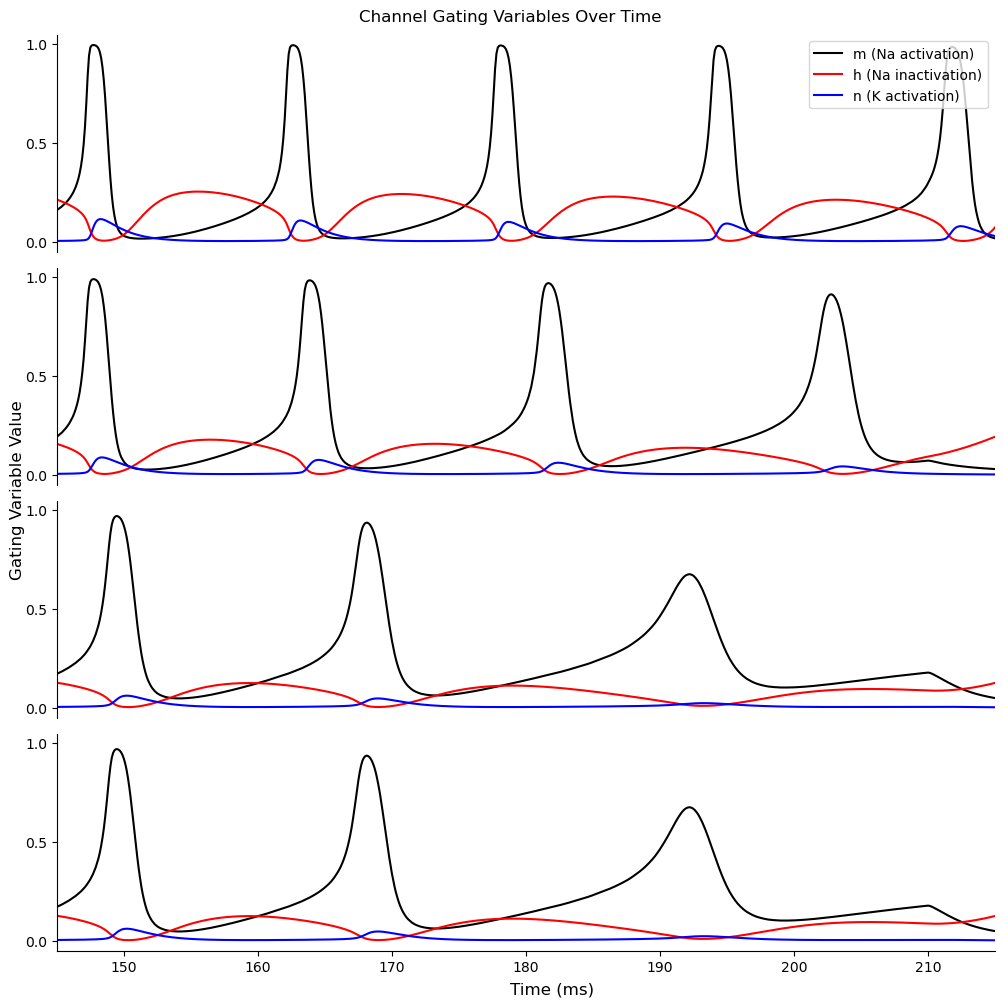

In [119]:
def arrange_axes(ax, i=0):
    if (i == 0):
        ax.legend(loc='upper right')    
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_gating_vars(ax, i=0, labels=[None,None,None]):
    if (i == 0):
        labels=['m (Na activation)', 'h (Na inactivation)', 'n (K activation)']
    ax.plot(sim_data['time [ms]'], sim_data['m'], color='black', label=labels[0])
    ax.plot(sim_data['time [ms]'], sim_data['h'], color='red', label=labels[1])
    ax.plot(sim_data['time [ms]'], sim_data['n'], color='blue', label=labels[2])
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlim(145, 215)

na = default_na
k = default_k
intensities_for_gating = [62.5, 65, 67.5, 70]
inten_len = len(intensities_for_gating)

fig, ax = plt.subplots(nrows=len(intensities_for_gating), ncols=1, figsize=(10, 10))
plt.suptitle('Channel Gating Variables Over Time')
fig.text(0, 0.5, 'Gating Variable Value', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0, 'Time (ms)', va='center', fontsize=12)

for i, intensity in enumerate(intensities_for_gating[:inten_len-1]):
    L5soma.change_biophysics({'gbar_na': na, 'gbar_kv': k})
    sim_data = simulate(L5soma, intensity, expanded_rec_vars)
    
    # Plot m, n, h functions on ax
    plot_gating_vars(ax[i], i)
    arrange_axes(ax[i], i)

plot_gating_vars(ax[inten_len-1], -1)
ax[inten_len-1].spines['top'].set_visible(False)
ax[inten_len-1].spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### (Na, K) = (0, 0)
Can't reach DB even at extreme intensities.

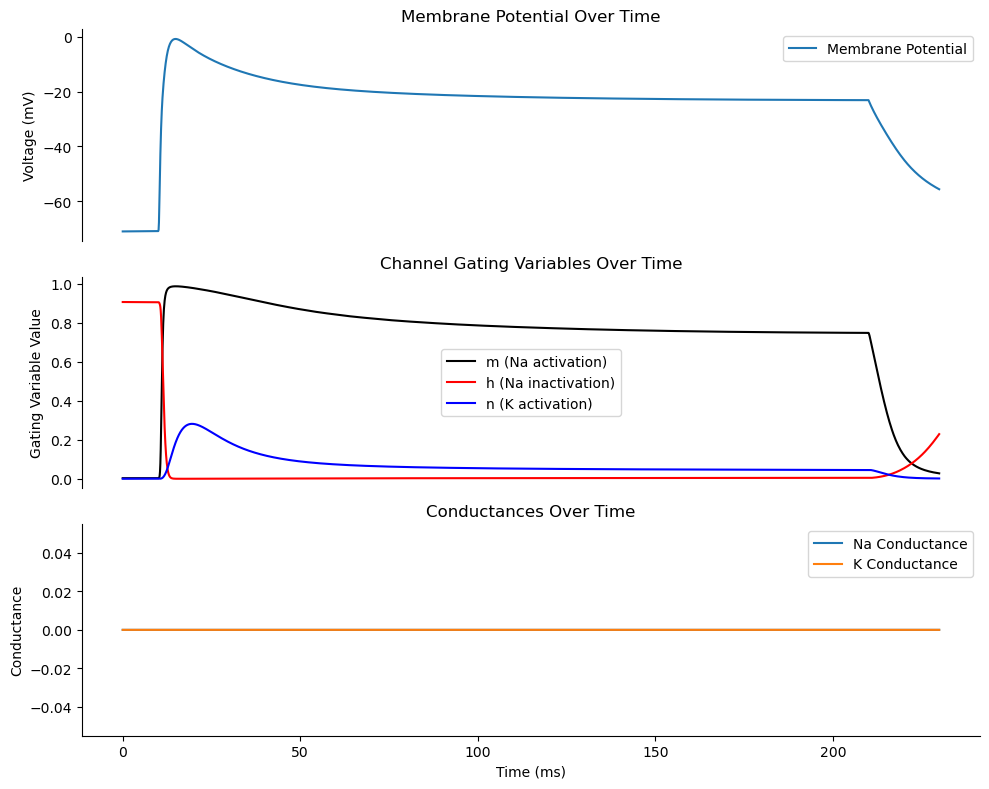

In [31]:
show_extended_sim_results(0, 0, 100_000)

### Ramping up Na conductance (with constant intensity)

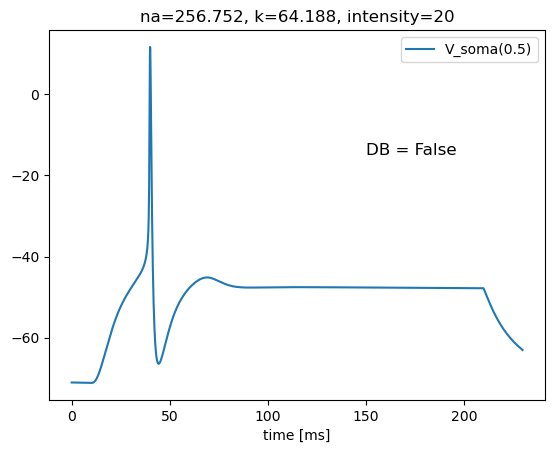

In [32]:
show_sim_result(256.752, 64.188, 20)

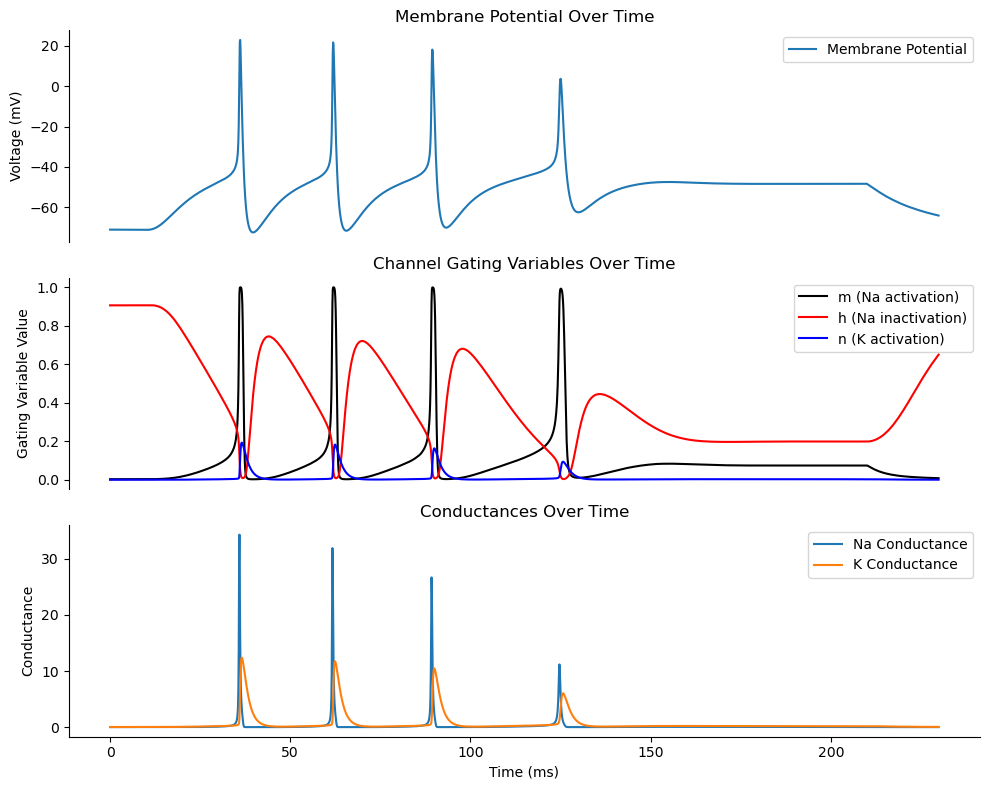

In [33]:
show_extended_sim_results(256.752 + 50, 64.188, 20)

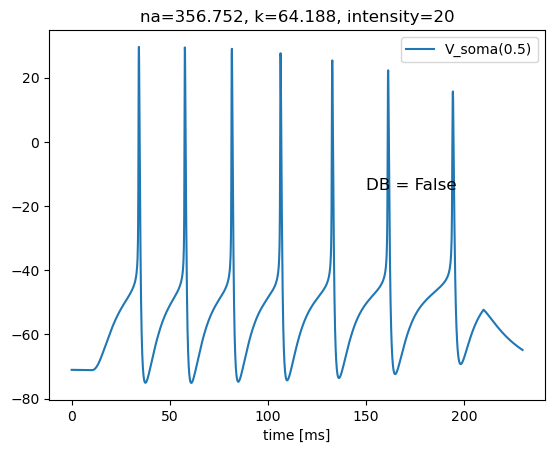

In [34]:
show_sim_result(256.752 + 100, 64.188, 20)

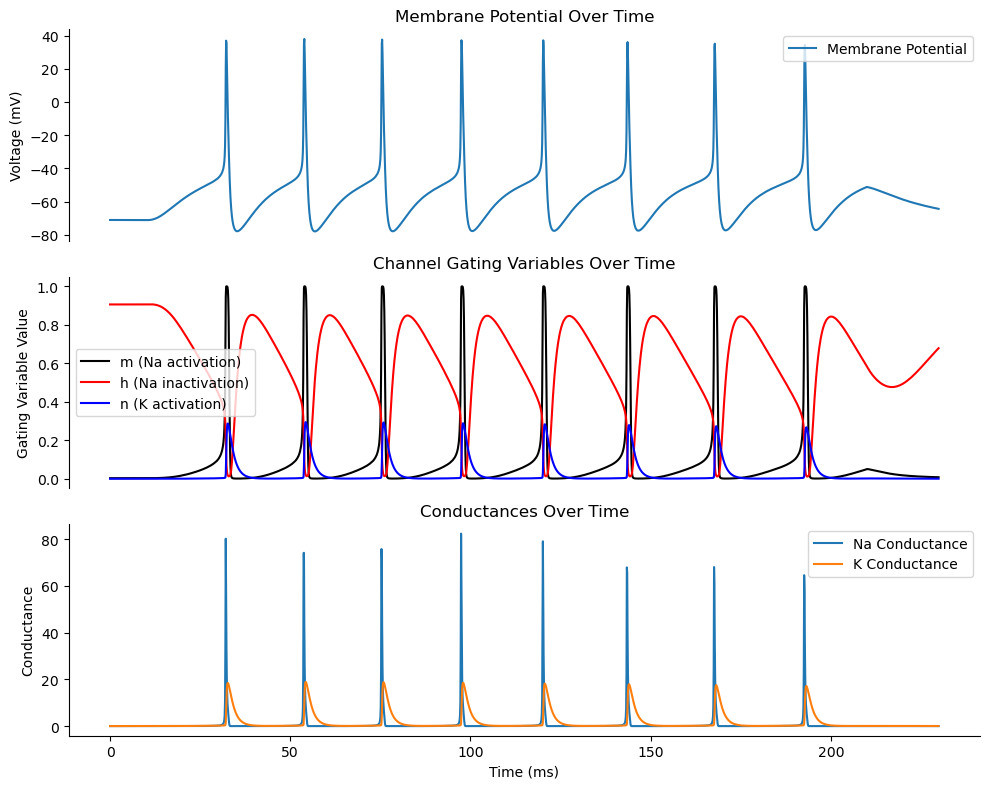

In [35]:
show_extended_sim_results(256.752 + 200, 64.188, 20)

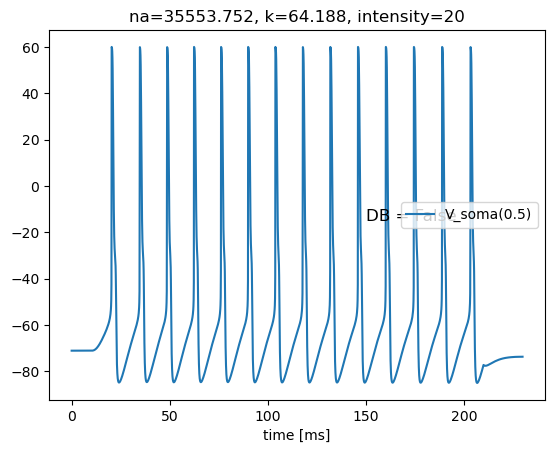

In [36]:
show_sim_result(256.752 + 35297, 64.188, 20) # not physiologically plausible

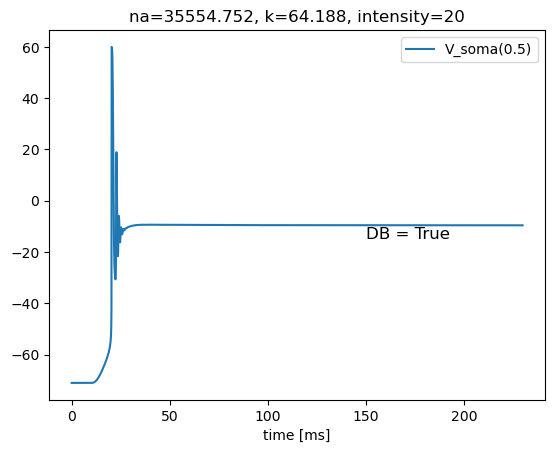

In [37]:
show_sim_result(256.752 + 35298, 64.188, 20) # not physiologically plausible

### Effect of size on susceptibility to DpB

VOLTAGE AT 200 ms: -38.287794567376835
101.470947265625
VOLTAGE AT 200 ms: -38.35012115354234
100.7080078125
VOLTAGE AT 200 ms: -38.31082184762387
101.470947265625
VOLTAGE AT 200 ms: -38.40533330931127
99.945068359375


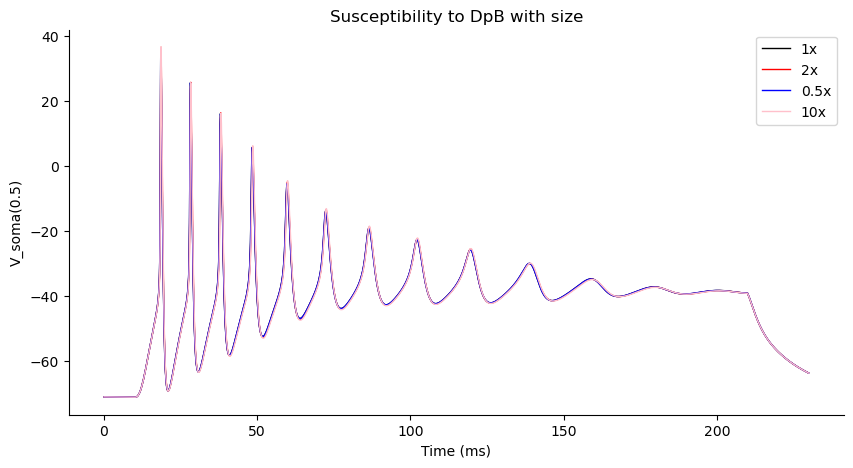

In [126]:
L5soma.change_biophysics({'gbar_na': default_na, 'gbar_kv': default_k})

zoomed = False
if zoomed:
    fig, ax = plt.subplots(figsize=(7, 5))
    line_width = 3
else:
    fig, ax = plt.subplots(figsize=(10, 5))
    line_width = 1


# Default size
intensity = find_intensity_threshold(L5soma, 1)

sim_data = simulate(L5soma, intensity)
ax.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], alpha=1, color='black', linewidth=line_width, label='1x')
print(f"VOLTAGE AT 200 ms: {sim_data[sim_data['time [ms]'] == 200]['V_soma(0.5)'].iloc[0]}")
print(intensity)

# Default size doubled
L5soma._scale_size_L(2)
intensity = find_intensity_threshold(L5soma, 1)

sim_data = simulate(L5soma, intensity)
ax.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], alpha=1, color='red', linewidth=line_width, label='2x')
print(f"VOLTAGE AT 200 ms: {sim_data[sim_data['time [ms]'] == 200]['V_soma(0.5)'].iloc[0]}")
print(intensity)

# Half the default size
L5soma._scale_size_L(0.25)
intensity = find_intensity_threshold(L5soma, 1)

sim_data = simulate(L5soma, intensity)
ax.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], alpha=1, color='blue', linewidth=line_width, label='0.5x')
print(f"VOLTAGE AT 200 ms: {sim_data[sim_data['time [ms]'] == 200]['V_soma(0.5)'].iloc[0]}")
print(intensity)

# Ten times the default size
L5soma._scale_size_L(20)
intensity = find_intensity_threshold(L5soma, 1)

sim_data = simulate(L5soma, intensity)
ax.plot(sim_data['time [ms]'], sim_data['V_soma(0.5)'], alpha=1, color='pink', linewidth=line_width, label='10x')
print(f"VOLTAGE AT 200 ms: {sim_data[sim_data['time [ms]'] == 200]['V_soma(0.5)'].iloc[0]}")
print(intensity)


# Set labels and title
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if zoomed:
    zoom_end = False

    if zoom_end:
        ax.set_xlim(170, 215)
        ax.set_ylim(-40, -37)
        ax.set_xticks([170, 175, 210, 215])
        ax.set_yticks([-40, -37])
    
        plt.savefig('size_effect_zoom.png', dpi=300)
    else:
        ax.set_xlim(18, 19)
        ax.set_ylim(30, 38)
        ax.set_xticks([18, 19])
        ax.set_yticks([30, 34, 38])

        plt.savefig('size_effect_zoom_first_spike.png', dpi=300)
else:
    ax.set_title('Susceptibility to DpB with size')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('V_soma(0.5)')
    ax.legend()
    plt.savefig('size_effect.png', dpi=300)
    
L5soma._scale_size_L(0.1)
plt.show()

In [39]:
sim_data

,time [ms],V_soma(0.5)
0,0.0,-71.044277
1,0.1,-71.045507
2,0.2,-71.046738
3,0.3,-71.047968
4,0.4,-71.049199
...,...,...
2295,229.5,-63.518684
2296,229.6,-63.567515
2297,229.7,-63.616347
2298,229.8,-63.665178
